# Generate data
This notebook describes how we generate the data used for machine learning on CrSBr STEM-HAADF images step-by-step. At the end of the notebook the collected scripts for data generations are available. 

The notebook is divided into 3 distinct parts
1. Generate a sample
2. Introduce defects and create label
3. Simulate STEM-HAADF image

The result of the workflow is to create a dataset in the form of a `.npy` file that can be loaded when training new neural networks. This dataset is augmented before the training to increase the dataset size, model experimental conditions and minimize overfitting. 

**Note**: the datasets used in this project are not included in this repository since they can be quite large, but you can create similar datasets by simply running the script at the end of the notebook. 

## Setup
We start by importing the needed functions to create a sample


In [2]:
from abtem import show_atoms
from ase.io import read
import matplotlib.pyplot as plt
import numpy as np

from helpers.generate_sample import generate_sample, displace_columns, generate_defects_by_column
from helpers.image_simulation import generate_STEM_image
from helpers.labels import defect_column_label
from helpers.fitting import show_wave

### Parameters
In this section we will define the different parameters that we will use throughout the notebook to create our samples.

In [3]:
parameters = {
    "energy": 200e3, # [eV]
    "size": [30,30], # [Å]
    "layers": [2,2],
    "gpts": 1024,
    "scanning_sampling": 0.0625, # [Å]
    "semiangle_cutoff": [12,27], # [mrad]
    "AD": [78, 200], # [mrad]
    "interpolation": 4,
    # Range of defocus [Å]
    "defocus": [-30,30],
    # Range of Cs [Å]
    "Cs": [0, 3e4],
    # Range of astigmatism [Å]
    "C12": [0, 40],
    # Range of coma [Å]
    "B2": [0, 500],
    # Path to save in
    "path": './data/datasets/',
    # Defect concentration
    "defect_chance": {"2Cr": {
                    "V-Cr": 0.15,
                    "2V-Cr": 0.15,
                    },
                "2Br&2S":{
                    "2V-Br": 0.15,
                    "V-Br": 0.15,
                    }
                }
}

## Generate a sample
In the following we use `ase` to create a sample, which is an atomic model of the compund of interest. To do this we have defined several functions within `helpers.generate_sample` which we use to create a random flake rotated randomly and slightly off-axis while also introducing several defects.

This model can then be utilized to create a label which will serve as a groundtruth showing the location of each of the different columns.

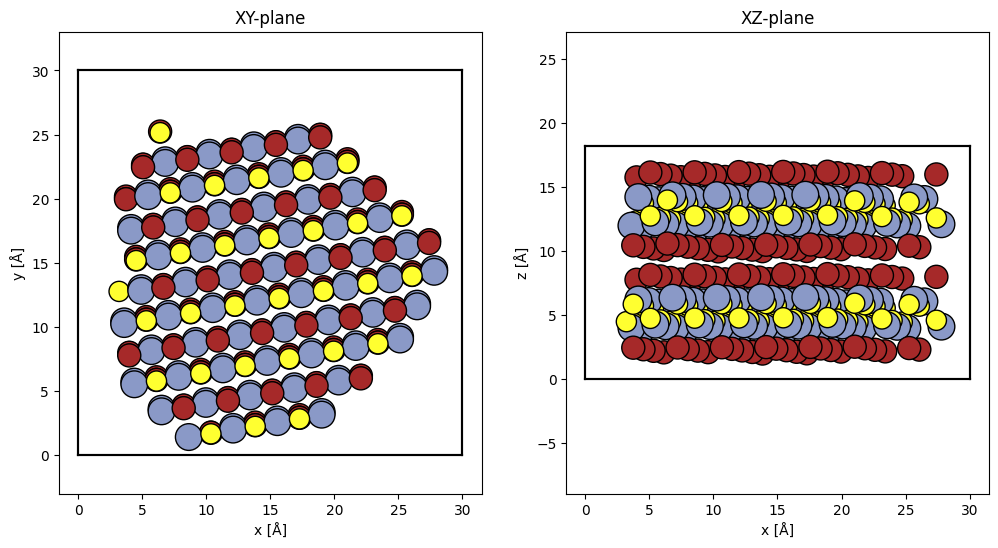

In [4]:
# Load atomic structure
atoms = read('./data/crystals/CrSBr.cif')

sample = generate_sample(atoms, parameters["size"], layers=parameters["layers"])

# visualize the structure
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))
show_atoms(sample, ax=ax1, title="XY-plane")
show_atoms(sample, ax=ax2, plane="xz", title="XZ-plane")
plt.show()

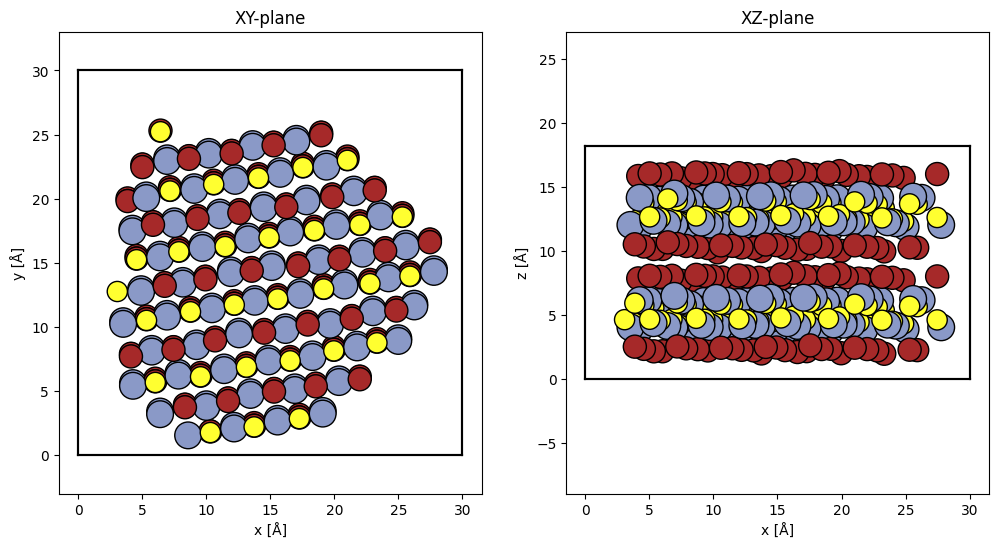

In [5]:
# We can now displace the columns sligthly so that we do not overfit to the ideal lattice
sample = displace_columns(sample, sigma=0.1)
# Likewise we can randomly remove some atoms to generalize to columns with defects

# visualize the structure
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))
show_atoms(sample, ax=ax1, title="XY-plane")
show_atoms(sample, ax=ax2, plane="xz", title="XZ-plane")
plt.show()

### Introduce defects and create label

We can now create the corresponding label using the functions from `helpers.labels` here we can create circular or gaussian labels depending on the paramater dictionary used.

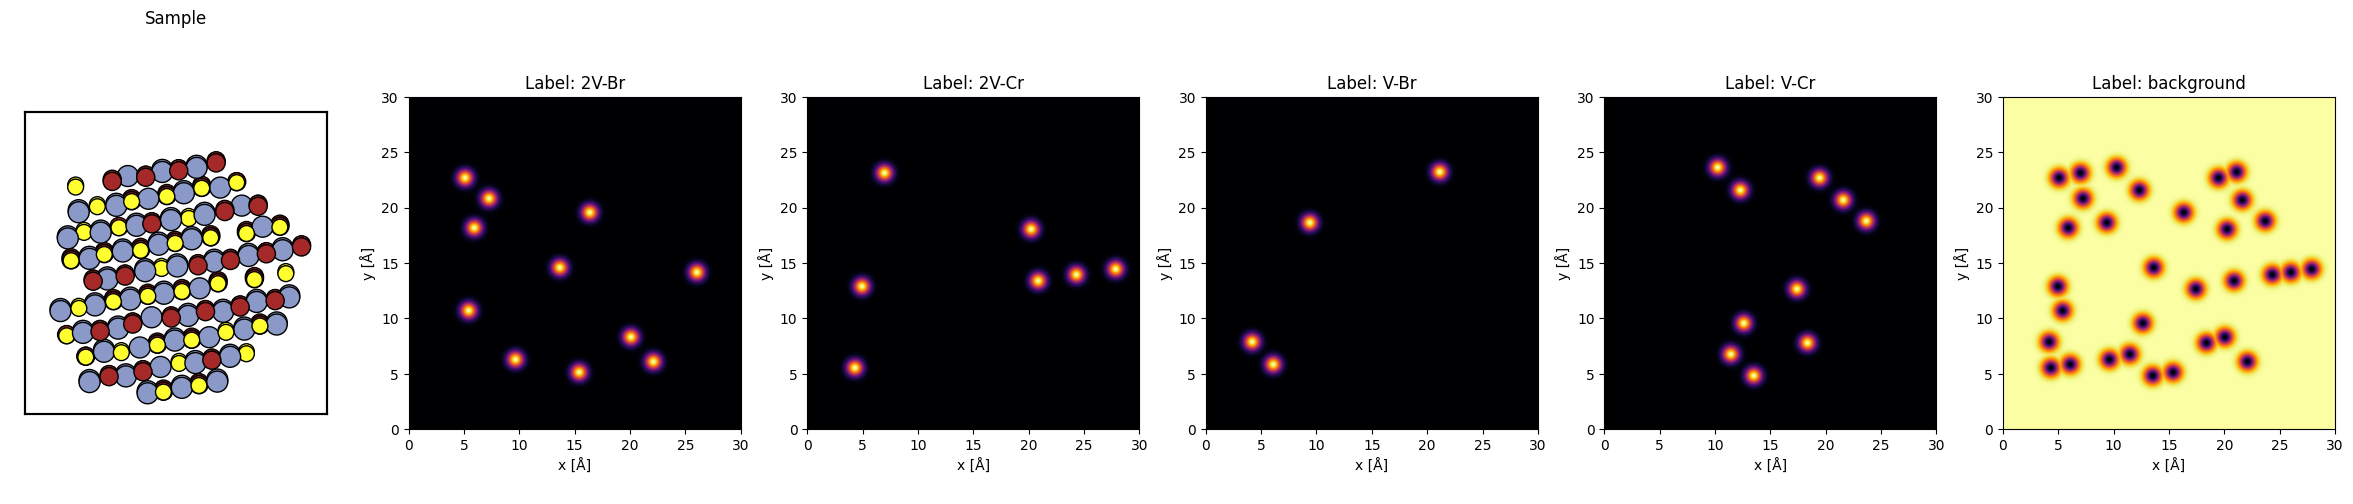

In [6]:
sample, defect_locations = generate_defects_by_column(sample, parameters["defect_chance"])
label, label_names = defect_column_label(defect_locations, parameters)

# visualize the structure  and label
fig, axs = plt.subplots(1,6,figsize=(30,6))
axs = axs.flatten()
show_atoms(sample, ax=axs[0], title="Sample")
axs[0].set_axis_off()
for i in range(len(label_names)):
    show_wave(label[i], sampling=parameters["scanning_sampling"], ax=axs[i+1], title=f"Label: {label_names[i]}")
plt.show()

## Simulate ideal image
We now have a sample which we can simulate a STEM-HAADF image of using the following helper function which utilizes `abTEM`. The notebook here makes use of GPU acceleration and the [PRISM algorithm](https://ascimaging.springeropen.com/articles/10.1186/s40679-017-0046-1) to speed-up simulations drastically. 

In [7]:
%time measurement, pars = generate_STEM_image(sample, parameters, True, gpu=True)

CPU times: user 11.1 s, sys: 8.15 s, total: 19.2 s
Wall time: 21.4 s


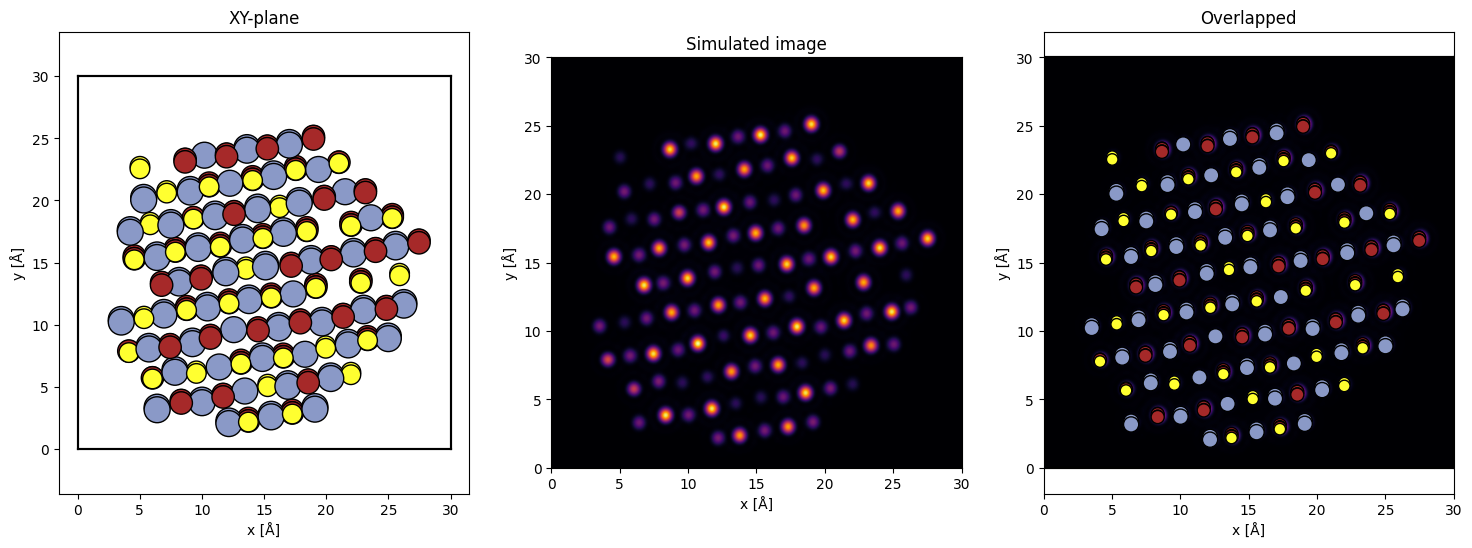

In [8]:
# visualize the structure  and simulation
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18,6))
show_atoms(sample, ax=ax1, title="XY-plane")
show_wave(measurement.array, sampling=parameters["scanning_sampling"], ax=ax2, title=f"Simulated image")
show_wave(measurement.array, sampling=parameters["scanning_sampling"], ax=ax3)
show_atoms(sample, ax=ax3, scale=0.4, title="Overlapped")
plt.show()

## Collected Script
Here is a collected version of the above script that will create a full dataset that later can be used for training.

In [ ]:
# Base imports
import os
import sys
# Mount directories for local imports
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Limit GPU memory usage with less workers
import dask
dask.config.set({"num_workers": 1})

# Other imports
from helpers.generate_sample import generate_sample, displace_columns, generate_defects, generate_defects_by_column, get_thermal_displacements
from helpers.image_simulation import generate_STEM_image
from helpers.labels import defect_column_label
from abtem.visualize import show_atoms
from ase.io import read
import matplotlib.pyplot as plt
import numpy as np

# Load atomic structure
atoms = read('../data/crystals/CrSBr.cif')
# Amount of samples to generate
N = 50
# Parameters
parameters = {
    "energy": 200e3,
    "size": [30,30],
    "layers": [2,2],
    "gpts": 1024,
    "scanning_sampling": 0.0625,
    "semiangle_cutoff": [12,27],
    "AD": [78, 200],
    "interpolation": 4,
    # Range of defocus [Å]
    "defocus": [-30,30],
    # Range of Cs [Å]
    "Cs": [0, 3e4],
    # Range of astigmatism [Å]
    "C12": [0, 40],
    # Range of coma [Å]
    "B2": [0, 500],
    # Path to save in
    "path": './data/datasets/',
    # Defect concentration
    "defect_chance": {"2Cr": {
                    "V-Cr": 0.15,
                    "2V-Cr": 0.15,
                    },
                "2Br&2S":{
                    "2V-Br": 0.15,
                    "V-Br": 0.15,
                    }
                }
}

# Empty lists to populate
labels = []
measurements = []
samples = []
ctf_parameters = []
all_defect_locations = []

#sigmas = get_thermal_displacements(atoms, T=parameters["T"], T_D=parameters["T_D"])
for i in range(N):
    sample = generate_sample(atoms, parameters["size"], layers=parameters["layers"])
    sample = displace_columns(sample, sigma=0.1)
    sample, defect_locations = generate_defects_by_column(sample, parameters["defect_chance"])
    label, label_names = defect_column_label(defect_locations, parameters)
    measurement, pars = generate_STEM_image(sample, parameters, True, gpu=True)#, N_frozen=parameters["N_frozen"], sigmas=sigmas)
    ## Make sure label names stay the same
    if i==0:
        old_label_names = label_names
    assert (label_names == old_label_names).all()
    old_label_names = label_names

    # add to arrays
    measurements.append(measurement.array)
    labels.append(label)
    samples.append(sample)
    ctf_parameters.append(pars)
    all_defect_locations.append(defect_locations)
    if (i%5)==0:
        print(f"Data generated [{i+1}/{N}]", flush=True)

# Save the files
os.makedirs(parameters["path"], exist_ok=True)
parameters["label_names"] = label_names
i = 0
while True:
    i +=  1
    if not os.path.isfile(parameters["path"]+f"dataset_{i}.npz"):
        break

np.savez_compressed(os.path.join(parameters["path"],f'dataset_{i}.npz'),
    labels = np.array(labels), measurements = np.array(measurements),
    samples = np.array(samples), ctf_parameters = np.array(ctf_parameters),
    parameters = parameters, defect_locations=all_defect_locations)